In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
labels = os.listdir("/content/gdrive/MyDrive/Driver drowsiness detection/train")

In [ ]:
labels

['Closed', 'yawn', 'no_yawn', 'Open']

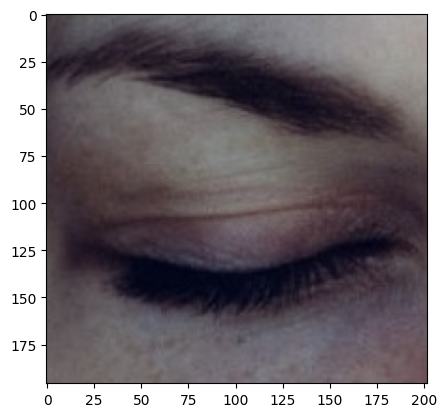

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("/content/gdrive/MyDrive/Driver drowsiness detection/train/Closed/_116.jpg"))

In [ ]:
a = plt.imread("/content/gdrive/MyDrive/Driver drowsiness detection/train/yawn/1.jpg")

In [ ]:
a.shape

(480, 640, 3)

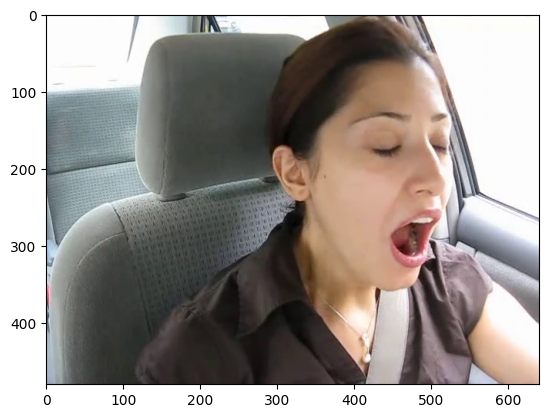

In [ ]:
plt.imshow(plt.imread("/content/gdrive/MyDrive/Driver drowsiness detection/train/yawn/1.jpg"))

In [ ]:
def face_for_yawn(direc="/content/gdrive/MyDrive/Driver drowsiness detection/train", face_cas_path="/content/gdrive/MyDrive/prediction/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [ ]:
def get_data(dir_path="/content/gdrive/MyDrive/Driver drowsiness detection/train", face_cas="/content/gdrive/MyDrive/prediction/haarcascade_frontalface_default.xml", eye_cas="/content/gdrive/MyDrive/prediction/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [ ]:
data_train = get_data()

2
3


In [ ]:
def append_data():
#     total_data = []
    yawn_no = face_for_yawn()
    data = get_data()
    yawn_no.extend(data)
    return yawn_no

In [ ]:
new_data = append_data()

0
1
2
3


In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
len(X_test)

578

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
import keras
keras.__version__

'2.15.0'

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 21s 236ms/step - loss: 1.0868 - accuracy: 0.5096 - val_loss: 0.5406 - val_accuracy: 0.7682
Epoch 2/50
43/43 [==============================] - 9s 209ms/step - loss: 0.4819 - accuracy: 0.8004 - val_loss: 0.3243 - val_accuracy: 0.8720
Epoch 3/50
43/43 [==============================] - 8s 174ms/step - loss: 0.3675 - accuracy: 0.8353 - val_loss: 0.3136 - val_accuracy: 0.8702
Epoch 4/50
43/43 [==============================] - 8s 175ms/step - loss: 0.3569 - accuracy: 0.8494 - val_loss: 0.2428 - val_accuracy: 0.9118
Epoch 5/50
43/43 [==============================] - 9s 206ms/step - loss: 0.2883 - accuracy: 0.8865 - val_loss: 0.2114 - val_accuracy: 0.9187
Epoch 6/50
43/43 [==============================] - 9s 220ms/step - loss: 0.2620 - accuracy: 0.8954 - val_loss: 0.2793 - val_accuracy: 0.8875
Epoch 7/50
43/43 [==============================] - 8s 183ms/step - loss: 0.2537 - accuracy: 0.8976 - val_loss: 0.2405 - val_accuracy: 0.8979
Epoch

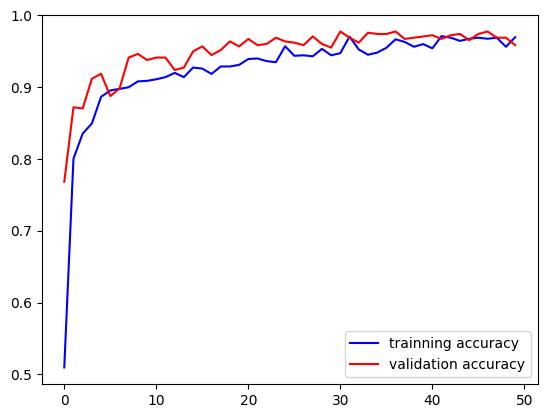

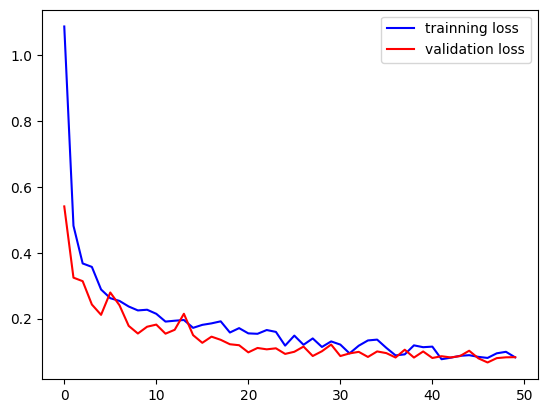

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
model.save("drowiness_new6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
prediction = np.argmax(model.predict(X_test),axis=1)

19/19 [==============================] - 1s 32ms/step


In [ ]:
prediction

array([2, 3, 3, 2, 1, 0, 3, 1, 3, 2, 0, 3, 2, 0, 3, 3, 0, 2, 2, 2, 3, 2,
       3, 2, 2, 2, 3, 1, 1, 3, 2, 1, 3, 1, 0, 1, 3, 3, 3, 2, 3, 2, 2, 0,
       0, 2, 3, 3, 2, 2, 2, 2, 3, 0, 3, 3, 3, 2, 3, 2, 3, 3, 3, 1, 2, 2,
       3, 1, 3, 3, 3, 2, 3, 2, 0, 2, 1, 0, 3, 2, 2, 3, 0, 3, 1, 3, 3, 2,
       3, 3, 3, 2, 0, 3, 2, 1, 1, 1, 3, 3, 1, 0, 3, 1, 0, 2, 2, 2, 2, 3,
       0, 2, 2, 1, 3, 0, 0, 3, 2, 3, 2, 3, 3, 2, 3, 2, 1, 2, 3, 2, 0, 3,
       3, 2, 3, 2, 1, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 0, 2, 3, 3,
       2, 3, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2,
       3, 3, 2, 0, 2, 3, 3, 2, 1, 3, 2, 3, 1, 2, 0, 2, 3, 2, 2, 0, 2, 2,
       0, 3, 3, 3, 0, 2, 0, 0, 3, 3, 2, 3, 0, 1, 1, 3, 2, 2, 3, 3, 3, 3,
       3, 0, 0, 1, 1, 3, 3, 3, 0, 2, 3, 0, 0, 2, 1, 2, 3, 2, 0, 1, 1, 0,
       1, 0, 0, 3, 3, 3, 3, 3, 1, 2, 2, 2, 2, 0, 0, 3, 3, 3, 0, 2, 3, 3,
       2, 3, 3, 3, 0, 2, 2, 3, 2, 3, 1, 3, 3, 3, 3, 0, 3, 0, 1, 3, 3, 3,
       2, 1, 1, 2, 2, 2, 1, 3, 0, 2, 3, 2, 3, 3, 3,

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.84      0.92      0.88        64
     no_yawn       0.93      0.86      0.90        74
      Closed       0.99      0.95      0.97       212
        Open       0.96      0.99      0.97       228

    accuracy                           0.95       578
   macro avg       0.93      0.93      0.93       578
weighted avg       0.95      0.95      0.95       578



In [ ]:
abels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="/content/gdrive/MyDrive/prediction/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new6.h5")

In [ ]:
prediction = model.predict([prepare("/content/gdrive/MyDrive/Driver drowsiness detection/train/no_yawn/1007.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 27ms/step


2

In [ ]:
prediction = model.predict([prepare("/content/gdrive/MyDrive/Driver drowsiness detection/train/Closed/_116.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 27ms/step


2

In [ ]:
prediction = model.predict([prepare("/content/gdrive/MyDrive/Driver drowsiness detection/train/Open/_0.jpg")])
np.argmax(prediction)


1/1 [==============================] - 0s 48ms/step


3

In [ ]:
prediction = model.predict([prepare("/content/gdrive/MyDrive/Driver drowsiness detection/train/yawn/1.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 18ms/step


3